In [10]:
from drone_v34 import *

In [11]:
@torch.no_grad()
def infer(env, bnn, threshold=None, max_episode_length=256, 
          n_action=None,
          verbose=False, seed=0, stop_at_collision=False, 
          spatial_prop=None, need_gif=None, 
          decompose=None, lie_derive_safe=None,
          only_show_collide=False):
    
    if spatial_prop is None:
        spatial_prop = SPATIAL_PROP
        
    if n_action is None:
        n_action = n_candidates
        
    if lie_derive_safe is None:
        lie_derive_safe = LIE_DERIVE_SAFE
    
    if threshold is None:
        threshold=THRESHOLD
    if verbose:
        print('----------------------------------------')
        
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    paths = [deepcopy(env.world.agents)]
    total_trans=0; n_danger=0; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool); thresholds=np.array([threshold]*env.num_agents)

    while True:
        a, v, feasibles, evil_agents = choose_action(bnn=bnn, env=env, explore_eps=0, 
                                                     nominal_eps=0, 
                                                     spatial_prop=spatial_prop, 
                                                     thresholds=thresholds,
                                                     n_action=n_action,
                                                     decompose=decompose)
        next_o, rw, done, info = env.step(a, obs_config=OBS_CONFIG)
        
        prev_danger = info['prev_danger'].data.cpu().numpy().astype(bool)
        next_danger = info['next_danger'].data.cpu().numpy().astype(bool)
        if np.any(next_danger):
            collided = collided | next_danger
        if verbose:
            print(total_trans, v.min(axis=-1), v.max(axis=-1), np.where(v<=thresholds), np.where(next_danger), evil_agents)
            
        total_trans += 1
        if lie_derive_safe:
            thresholds = 0.9*v+1e-2

        paths.append(deepcopy(env.world.agents))

        if np.any(next_danger) and stop_at_collision:
            break        
        
        if done or (total_trans >= max_episode_length):
            break
            
    if (need_gif is not None):
        if (not only_show_collide) or (np.any(collided)):
            env.save_fig(paths, env.world.agent_goals, env.world.obstacles, need_gif[:-4]+'_'+str(np.any(collided))+'_'+str(done)+need_gif[-4:])

    return collided, done, paths

In [14]:
bnn = create_network()
bnn.load_state_dict(torch.load(BMODEL_PATH))
bnn.to(device)

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py:53: UserWarning: There exist node types ({'obstacle'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


OriginGNNv11(
  (embed): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (edge_embed): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
    (1): HeteroConv(num_relations=2)
    (2): HeteroConv(num_relations=2)
  )
  (edge_mlps): ModuleList(
    (0): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (1): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_fe

In [281]:
seed = 10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
env = create_env(num_agents=8, size=4, density=30)
env.world.agents[:,3:6] = 0
collided, done, paths = infer(env, bnn, n_action=10000, max_episode_length=30, verbose=True, decompose='random', need_gif=None)

----------------------------------------
0 0.07678515464067459 0.10714616626501083 (array([], dtype=int64),) (array([], dtype=int64),) set()
1 0.09741892665624619 0.10802697390317917 (array([], dtype=int64),) (array([], dtype=int64),) set()
2 0.10112638026475906 0.10717456787824631 (array([], dtype=int64),) (array([], dtype=int64),) set()
3 0.10404696315526962 0.1099182590842247 (array([], dtype=int64),) (array([], dtype=int64),) set()
4 0.1029771938920021 0.10774547606706619 (array([], dtype=int64),) (array([], dtype=int64),) set()
5 0.10168316215276718 0.10778870433568954 (array([], dtype=int64),) (array([], dtype=int64),) set()
6 0.09711893647909164 0.1070118173956871 (array([], dtype=int64),) (array([], dtype=int64),) set()
7 0.08515044301748276 0.1059361919760704 (array([], dtype=int64),) (array([], dtype=int64),) set()
8 0.07603774219751358 0.10515560954809189 (array([], dtype=int64),) (array([], dtype=int64),) set()
9 0.036174893379211426 0.10604781657457352 (array([], dtype=int

In [127]:
geo_data = list(env._get_obs_random_k(**OBS_CONFIG_DECOMPOSE))

In [148]:
actions = np.meshgrid(*([np.linspace(-1, 1, 21)]*3))
actions = np.array(actions).reshape(3, -1).T.reshape(-1, 3)
candidates = np.hstack((actions, np.zeros((len(actions), 1))))
candidates = np.tile(candidates[np.newaxis,:], (env.num_agents, 1, 1))

In [275]:
%%time
v = np.array([eval_action(bnn, o, candidates)[1] for o in geo_data]).min(axis=0)

CPU times: user 97.5 ms, sys: 11.8 ms, total: 109 ms
Wall time: 25.3 ms


In [240]:
agent_id = 1
a, b, c = candidates[agent_id,:,:-1].T
z = v[agent_id]

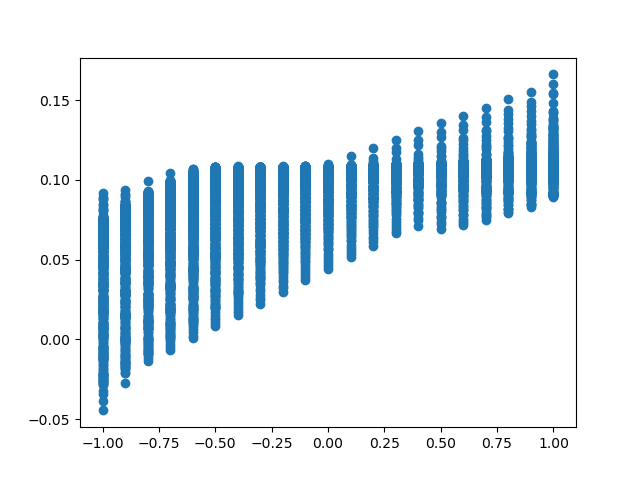

In [241]:
plt.close('all')
plt.clf()
plt.scatter(c, z)
plt.show()

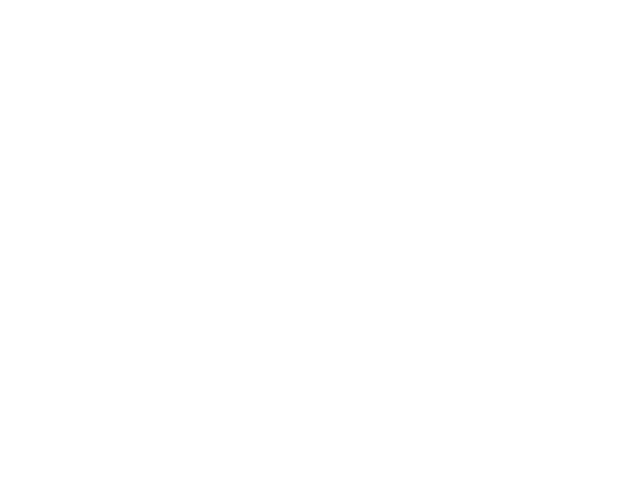

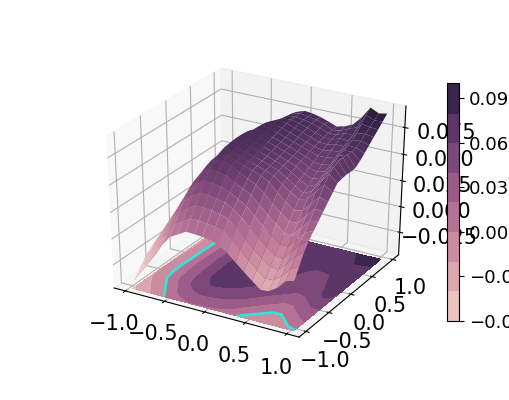

In [298]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

x = a.reshape(21, 21, -1)[...,0]
y = b.reshape(21, 21, -1)[...,0]
z = z.reshape(21, 21, -1)[...,0]

plt.close('all')
plt.clf()
fig = plt.figure(figsize=(5.1,4))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z.reshape(21, 21), cmap=sns.cubehelix_palette(as_cmap=True))
c = ax.contourf(x, y, z, zdir='z', offset=-0.05, cmap=sns.cubehelix_palette(as_cmap=True))
CS = plt.contour(x, y, z, levels = [0], zdir='z', offset=-0.05,
                 colors=((55/256, 226/256, 213/256),),linestyles=('-',),linewidths=(2,))
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.set_xticks([-1, -0.5, 0, 0.5, 1.0])
ax.set_yticks([-1, -0.5, 0, 0.5, 1.0])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='z', labelsize=15)
ax.zaxis.set_tick_params(pad=10.5)
cbar = fig.colorbar(c, ax=ax, fraction=0.03, pad=0.01, extend='neither', spacing='proportional', ticks=[-0.06, -0.03, 0.0, 0.03, 0.06, 0.09])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='z', labelsize=15)
cbar.ax.tick_params(labelsize=13)

In [301]:
fig.tight_layout()
plt.savefig('landscape3.pdf')